# 1. PBMC data of immune cells from young and old, male and female samples

Huang, Zhaohao, Binyao Chen, Xiuxing Liu, He Li, Lihui Xie, Yuehan Gao, Runping Duan, et al. 2021. “Effects of Sex and Aging on the Immune Cell Landscape as Assessed by Single-Cell Transcriptomic Analysis.” Proceedings of the National Academy of Sciences of the United States of America 118 (33). https://doi.org/10.1073/pnas.2023216118.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro

# scCODA functions
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
print(f"sccoda version: {sccoda.__version__}")

#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

2023-06-30 17:23:08.066074: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 17:23:08.069021: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 17:23:08.135767: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 17:23:08.137265: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 17:23:09.087898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

sccoda version: 0.1.9


In [2]:
#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
# path where figures are going to be saved
FIG_PATH = 'plots'

In [4]:
def convert_counts_to_df(counts, prop_cols=None, meta_cols=None, n_cells=1, column_name="Cluster"):
    """ Convert a cell count matrix to a dataframe in long format."""

    counts = counts.copy()

    #If not given, try to get prop_cols and meta_cols automatically
    if prop_cols is None:
        dtypes = counts.dtypes.astype(str)
        prop_cols = [col for i, col in enumerate(counts.columns) if "float" in dtypes[i] or "int" in dtypes[i]]
        
    if meta_cols is None:
        meta_cols = [col for col in counts.columns if col not in prop_cols]

    # Multiply proportions with n_cells
    counts[prop_cols] *= n_cells
    counts[prop_cols] = counts[prop_cols].astype(int)
    
    # Melt into long format (similar to adata.obs)
    counts_melt = pd.melt(counts, id_vars=meta_cols, value_vars=prop_cols, 
                          var_name=column_name, value_name="count")

    # Duplicate rows based on number of cells
    counts_long = counts_melt.loc[counts_melt.index.repeat(counts_melt["count"])].reset_index(drop=True)
    counts_long.drop(columns="count", inplace=True)
    counts_long.index = ["cell_" + str(i) for i in range(1, len(counts_long) + 1)]
    
    return counts_long

------------------

## Read data

In [5]:
pbmc_counts = pd.read_csv("data/pbmc_counts.tsv", sep="\t")

In [6]:
pbmc_counts.head()

,Sample,Condition,Sex,Age,BC,DC,MC,NK,TC
0,OF1,OF,female,old,1449,135,1342,1328,4574
1,OF2,OF,female,old,677,148,2159,746,5097
2,OF3,OF,female,old,552,124,1507,1108,5535
3,OF4,OF,female,old,666,146,1277,589,6151
4,OF5,OF,female,old,653,137,2027,1632,4379


In [7]:
# Convert count matrix to long format
pbmc = convert_counts_to_df(pbmc_counts, column_name="Celltype")
pbmc.head()

,Sample,Condition,Sex,Age,Celltype
cell_1,OF1,OF,female,old,BC
cell_2,OF1,OF,female,old,BC
cell_3,OF1,OF,female,old,BC
cell_4,OF1,OF,female,old,BC
cell_5,OF1,OF,female,old,BC


-------

## Run Scanpro

### Young vs Old

In [8]:
pbmc_young_old = scanpro.scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Age')
pbmc_young_old.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_old,mean_props_young,prop_ratio,t_statistics,p_values,adjusted_p_values
Celltype,,,,,,,
BC,0.098383,0.094222,0.102401,0.920131,-0.820623,0.415756,0.519695
DC,0.017112,0.016362,0.018018,0.908097,-0.253956,0.800571,0.800571
MC,0.171416,0.196655,0.143211,1.373180,2.611481,0.011870,0.059349
NK,0.146479,0.158121,0.133477,1.184627,1.080974,0.284895,0.474825
TC,0.566610,0.534640,0.602892,0.886791,-1.781326,0.080934,0.202334


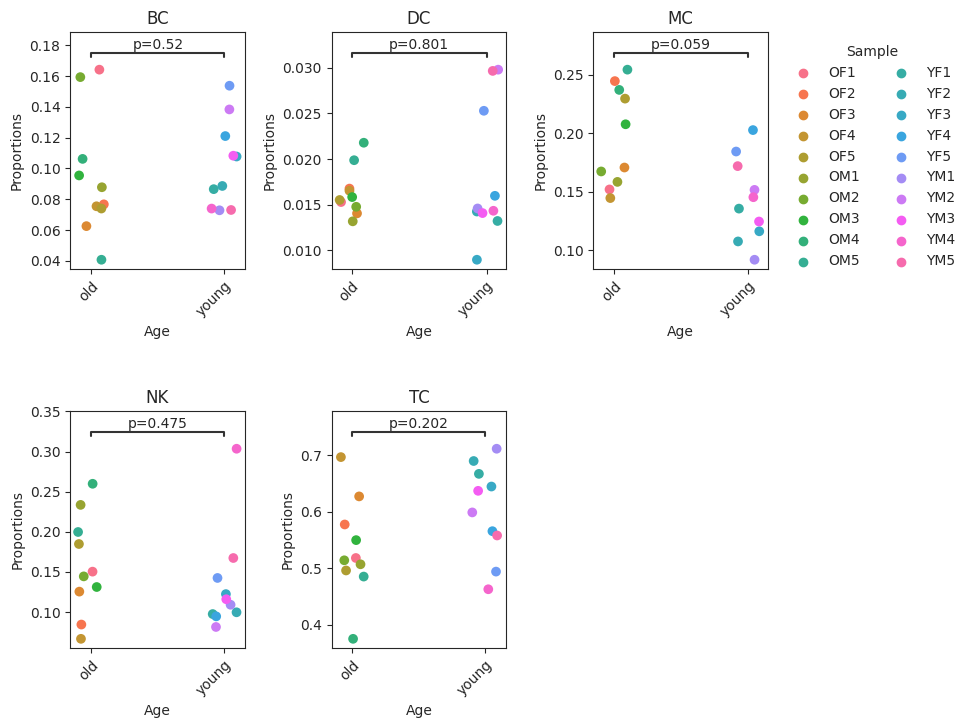

In [9]:
pbmc_young_old.plot(save="plots/pbmc_age_stripplot.pdf")

#### With sex as covariate

In [10]:
pbmc_young_old_sex = scanpro.scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Age', 
                                     covariates=["Sex"])
pbmc_young_old_sex.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_old,mean_props_young,prop_ratio,t_statistics,p_values,adjusted_p_values
Celltype,,,,,,,
BC,0.098383,0.094222,0.102401,0.920131,-0.847158,0.399286,0.499107
DC,0.017112,0.016362,0.018018,0.908097,-0.242931,0.808644,0.808644
MC,0.171416,0.196655,0.143211,1.373180,2.451117,0.016290,0.081450
NK,0.146479,0.158121,0.133477,1.184627,1.219577,0.225998,0.376664
TC,0.566610,0.534640,0.602892,0.886791,-1.784760,0.077868,0.194670


### Male vs Female

In [11]:
pbmc_male_female = scanpro.scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Sex')
pbmc_male_female.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_female,mean_props_male,prop_ratio,t_statistics,p_values,adjusted_p_values
Celltype,,,,,,,
BC,0.098383,0.101042,0.095581,1.057138,0.453546,0.651248,0.814059
DC,0.017112,0.015587,0.018793,0.829422,-1.052536,0.295371,0.492285
MC,0.171416,0.168821,0.171046,0.986995,-0.063694,0.949355,0.949355
NK,0.146479,0.116914,0.174684,0.669285,-2.637317,0.009844,0.049221
TC,0.566610,0.597636,0.539896,1.106946,1.448420,0.150975,0.377437


In [12]:
pbmc_male_female.results.to_csv("results/pbmc_scanpro_rep.tsv", sep="\t")

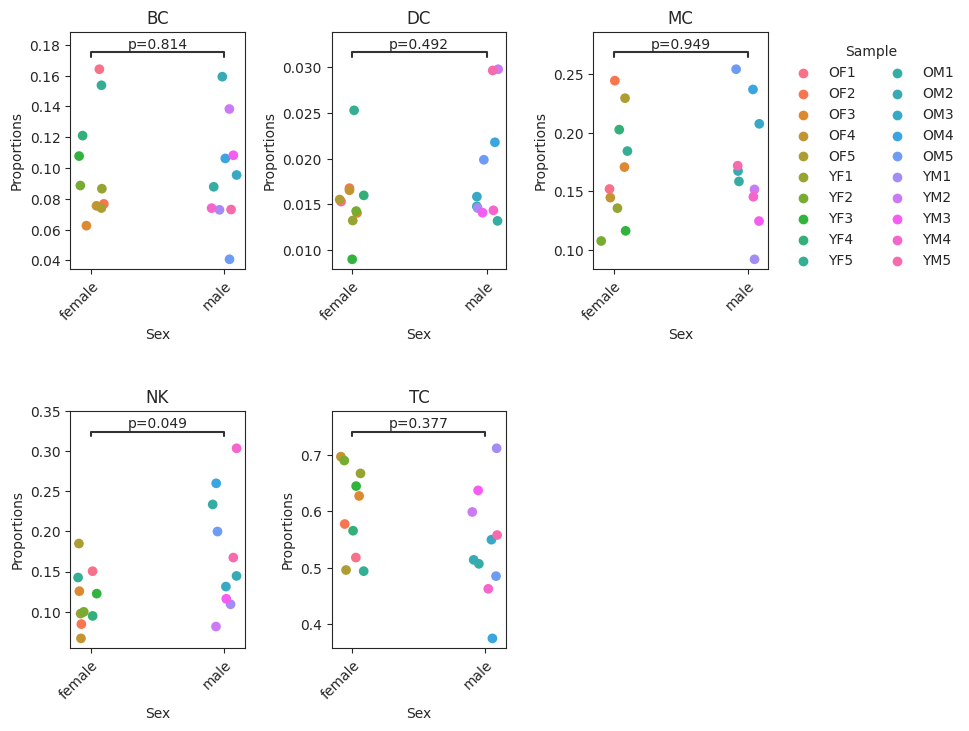

In [13]:
pbmc_male_female.plot(save=f"{FIG_PATH}/pbmc_sex_stripplot.pdf")

#### With age as covariate

In [14]:
pbmc_male_female_age = scanpro.scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Sex', covariates="Age")
pbmc_male_female_age.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_female,mean_props_male,prop_ratio,t_statistics,p_values,adjusted_p_values
Celltype,,,,,,,
BC,0.098383,0.101042,0.095581,1.057138,0.465948,0.642444,0.803055
DC,0.017112,0.015587,0.018793,0.829422,-1.093562,0.277237,0.462061
MC,0.171416,0.168821,0.171046,0.986995,-0.066221,0.947357,0.947357
NK,0.146479,0.116914,0.174684,0.669285,-2.697454,0.008425,0.042124
TC,0.566610,0.597636,0.539896,1.106946,1.498186,0.137790,0.344474


## Run Scanpro without replicates

In [15]:
pbmc_male_female_norep = scanpro.scanpro(pbmc, clusters_col='Celltype', conds_col='Sex')

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 39.96 seconds


In [16]:
pbmc_male_female_norep.results.to_csv("results/pbmc_scanpro_norep.tsv", sep="\t")

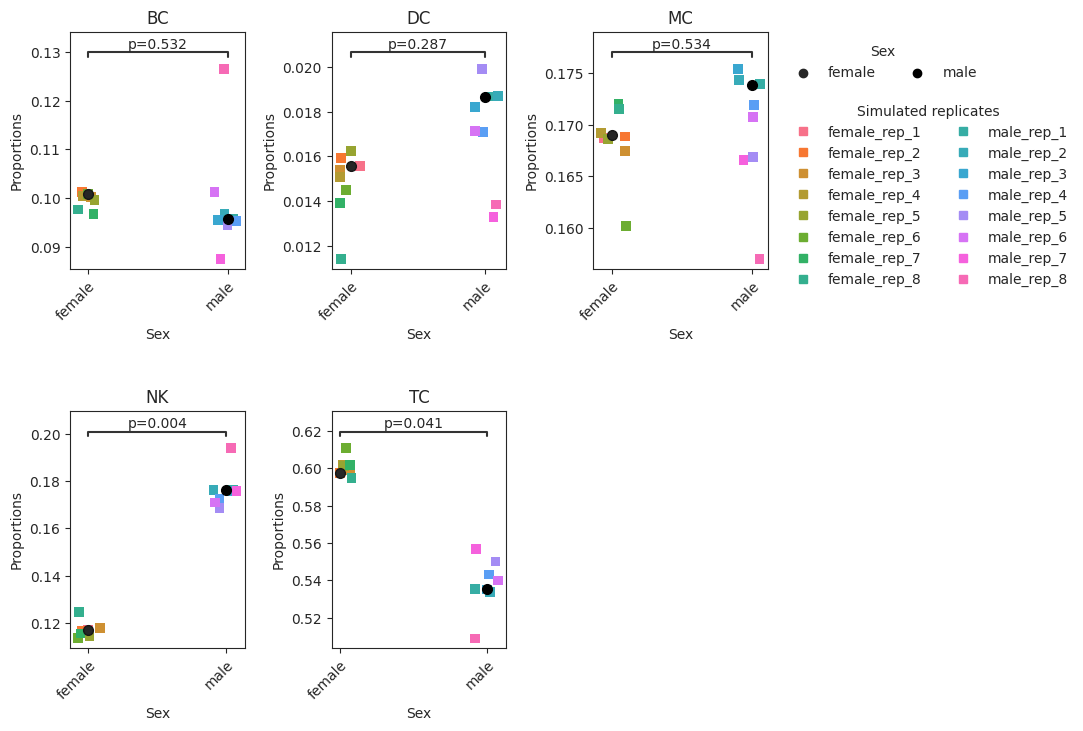

In [17]:
pbmc_male_female_norep.plot(save="plots/pbmc_sex_norep_stripplot.pdf")

-----------------------

## Run propeller

In [18]:
%%R -i pbmc -o propeller_results
library(speckle)

propeller_results = propeller(clusters = pbmc$Celltype, sample = pbmc$Sample, group = pbmc$Sex)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
Performing logit transformation of proportions
group variable has 2 levels, t-tests will be performed


In [19]:
propeller_results

,BaselineProp.clusters,BaselineProp.Freq,PropMean.female,PropMean.male,PropRatio,Tstatistic,P.Value,FDR
NK,NK,0.146479,0.116914,0.174684,0.669285,-2.637317,0.009844,0.049221
TC,TC,0.566610,0.597636,0.539896,1.106946,1.448420,0.150975,0.377437
DC,DC,0.017112,0.015587,0.018793,0.829422,-1.052536,0.295371,0.492285
BC,BC,0.098383,0.101042,0.095581,1.057138,0.453546,0.651248,0.814059
MC,MC,0.171416,0.168821,0.171046,0.986995,-0.063694,0.949355,0.949355


In [20]:
propeller_results.to_csv("results/pbmc_propeller_rep.tsv", sep="\t")

-------------

## Run scCODA

### Data preparation

In [21]:
# With replicates
sccoda_data = dat.from_pandas(pbmc_counts, covariate_columns=["Sample", "Condition", "Age", "Sex"])

# Without replicates
counts_merged = pbmc_counts.groupby("Sex").sum(numeric_only=True).reset_index()
sccoda_data_norep = dat.from_pandas(counts_merged, covariate_columns=["Sex"])

### With replicates

In [22]:
sccoda_model = mod.CompositionalAnalysis(sccoda_data, formula="Sex", reference_cell_type="automatic")
sccoda_results = sccoda_model.sample_hmc()

Automatic reference selection! Reference cell type set to DC
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-06-30 17:24:18.436511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-06-30 17:24:18.436642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-06-30 17:24:18.447676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-06-30 17:24:18.447783: I tens

2023-06-30 17:24:18.966564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,20]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:24:19.230404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:24:19.265244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): I

MCMC sampling finished. (155.338 sec)
Acceptance rate: 25.6%


In [23]:
sccoda_results.summary()

Compositional Analysis summary:

Data: 20 samples, 5 cell types
Reference index: 1
Formula: Sex

Intercepts:
           Final Parameter  Expected Sample
Cell Type                                  
BC                   0.226      1022.196260
DC                  -0.186       677.025398
MC                   0.243      1039.722144
NK                  -4.929         5.898563
TC                   1.992      5977.207635


Effects:
                       Final Parameter  Expected Sample  log2-fold change
Covariate   Cell Type                                                    
Sex[T.male] BC                     0.0      1022.196260               0.0
            DC                     0.0       677.025398               0.0
            MC                     0.0      1039.722144               0.0
            NK                     0.0         5.898563               0.0
            TC                     0.0      5977.207635               0.0


In [24]:
sccoda_out =sccoda_results.credible_effects().to_frame(name="credible_effect")
sccoda_out.to_csv("results/pbmc_sccoda_rep.tsv", sep="\t")
sccoda_out

credible_effect
Covariate   Cell Type                 
Sex[T.male] BC                   False
            DC                   False
            MC                   False
            NK                   False
            TC                   False

### Without replicates

In [25]:
credeff_list = []
for _ in range(10):
    pbmc_model_norep = mod.CompositionalAnalysis(sccoda_data_norep, formula="Sex", reference_cell_type="automatic")
    sccoda_results_norep = pbmc_model_norep.sample_hmc()
    credeff_list.append(sccoda_results_norep.credible_effects())

Automatic reference selection! Reference cell type set to MC


2023-06-30 17:27:13.314683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-06-30 17:27:13.314804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-06-30 17:27:13.325291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-06-30 17:27:13.325399: I tens

2023-06-30 17:27:13.818942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:27:14.072402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:27:14.104835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (114.421 sec)
Acceptance rate: 43.9%
Automatic reference selection! Reference cell type set to MC


2023-06-30 17:29:27.128595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:29:27.159040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:29:27.407639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (123.377 sec)
Acceptance rate: 56.0%
Automatic reference selection! Reference cell type set to MC


2023-06-30 17:31:50.069500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:31:50.100444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:31:50.356313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (118.480 sec)
Acceptance rate: 54.0%
Automatic reference selection! Reference cell type set to MC


2023-06-30 17:34:07.664124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:34:07.695114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:34:07.942626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (114.430 sec)
Acceptance rate: 60.4%
Automatic reference selection! Reference cell type set to MC


2023-06-30 17:36:22.005613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:36:22.035544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:36:22.282775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (114.586 sec)
Acceptance rate: 76.9%


/home/mbentse/.conda/envs/scanpro_analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Automatic reference selection! Reference cell type set to MC


2023-06-30 17:38:36.189927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:38:36.225121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:38:36.501599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (114.663 sec)
Acceptance rate: 0.0%


/home/mbentse/.conda/envs/scanpro_analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Automatic reference selection! Reference cell type set to MC


2023-06-30 17:40:50.068633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:40:50.099567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:40:50.347615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (115.378 sec)
Acceptance rate: 50.5%
Automatic reference selection! Reference cell type set to MC


2023-06-30 17:43:04.905175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:43:04.936969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:43:05.187336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (116.902 sec)
Acceptance rate: 68.3%
Automatic reference selection! Reference cell type set to MC


2023-06-30 17:45:21.012299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:45:21.043137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:45:21.292760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (116.355 sec)
Acceptance rate: 25.9%
Automatic reference selection! Reference cell type set to MC


2023-06-30 17:47:37.195586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-06-30 17:47:37.225834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-06-30 17:47:37.473404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (118.200 sec)
Acceptance rate: 13.3%


In [26]:
# Collect credible effects
all_credeff = pd.concat(credeff_list)
pct_credeff = all_credeff.groupby(all_credeff.index.names).mean().to_frame("pct_credible_effect") * 100
pct_credeff

pct_credible_effect
Covariate   Cell Type                     
Sex[T.male] BC                        10.0
            DC                         0.0
            MC                         0.0
            NK                        20.0
            TC                        10.0

In [27]:
pct_credeff.to_csv("results/pbmc_sccoda_norep.tsv", sep="\t")